In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import timedelta
from functools import reduce

In [2]:

# Define the ticker symbols
tickers = {
    'BTC-USD': 'BTC',
    '^TNX': 'RF',
    'SPY': 'SPY',
    '^VIX': 'VIX'
}

# Define the date range
start_date = pd.to_datetime('2019-11-01')
end_date = pd.to_datetime('2024-10-31')

# Initialize an empty dictionary to store DataFrames
data_frames = {}

# Loop through each ticker and download the data
for ticker, name in tickers.items():
    # Download the data
    data = yf.download(ticker, start=start_date-timedelta(days=201), end=end_date)
    
    # Reset index to make 'Date' a column
    data = data.reset_index()
    
    # Convert 'Date' to datetime.date format
    data['date'] = pd.to_datetime(data['Date']).dt.date
    
    # Select relevant columns and rename them
    if ticker == 'BTC-USD':
        # For Bitcoin, keep 'Close' and 'Volume'
        data = data[['date', 'Close', 'Volume']]
        data.rename(columns={'Close': 'PRC', 'Volume': 'Vol'}, inplace=True)
    elif ticker == '^TNX':
        # For 10-year Treasury Yield, keep 'Close' and adjust yield to percentage
        data = data[['date', 'Close']]
        data.rename(columns={'Close': 'RF'}, inplace=True)
        # Convert yield from percentage points to decimal (e.g., 15.00 to 0.15)
        data['RF'] = data['RF'] / 100
    else:
        # For SPY and VIX, keep 'Adj Close'
        data = data[['date', 'Adj Close']]
        data.rename(columns={'Adj Close': name}, inplace=True)
    
    # Store the DataFrame in the dictionary
    data_frames[name] = data

# Merge all DataFrames on 'date'

dfs = list(data_frames.values())
merged_data = reduce(lambda left, right: pd.merge(left, right, on='date', how='inner'), dfs)
merged_data.columns = merged_data.columns.get_level_values(0) 
merged_data['Chg'] = merged_data['PRC']/merged_data['PRC'].shift()-1

merged_data


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_32187/2439375470.py:49: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  merged_data = reduce(lambda left, right: pd.merge(left, right, on='date', how='inner'), dfs)
/tmp/ipykernel_32187/2439375470.py:49: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  merged_data = reduce(lambda left, right: pd.merge(left, right, on='date', how='inner'), dfs)
/tmp/ipykernel_32187/2439375470.py:49: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  merged_data = reduce(lambda left, right: pd.merge(left, right, on='date', how='inner'

Price,date,PRC,Vol,RF,SPY,VIX,Chg
0,2019-04-15,5067.108398,12290155061,0.02553,265.896271,12.320000,NaN
1,2019-04-16,5235.559570,11618660197,0.02592,266.070496,12.180000,0.033244
2,2019-04-17,5251.937988,12438480677,0.02592,265.419495,12.600000,0.003128
3,2019-04-18,5298.385742,13256489918,0.02560,265.942108,12.090000,0.008844
4,2019-04-22,5399.365234,14601631648,0.02590,266.171295,12.420000,0.019059
...,...,...,...,...,...,...,...
1392,2024-10-24,68161.054688,31414428647,0.04200,579.239990,19.080000,0.026024
1393,2024-10-25,66642.414062,41469984306,0.04232,579.039978,20.330000,-0.022280
1394,2024-10-28,69907.757812,38799856657,0.04278,580.830017,19.799999,0.048998
1395,2024-10-29,72720.492188,58541874402,0.04274,581.770020,19.340000,0.040235


In [4]:
# create the signal for the trading range breakout
lookback_period = 150
merged_data['SUP'] = merged_data['PRC'].shift(1).rolling(window=lookback_period).min()
merged_data['RES'] = merged_data['PRC'].shift(1).rolling(window=lookback_period).max()
merged_data

Price,date,PRC,Vol,RF,SPY,VIX,Chg,SUP,RES
0,2019-04-15,5067.108398,12290155061,0.02553,265.896271,12.320000,NaN,NaN,NaN
1,2019-04-16,5235.559570,11618660197,0.02592,266.070496,12.180000,0.033244,NaN,NaN
2,2019-04-17,5251.937988,12438480677,0.02592,265.419495,12.600000,0.003128,NaN,NaN
3,2019-04-18,5298.385742,13256489918,0.02560,265.942108,12.090000,0.008844,NaN,NaN
4,2019-04-22,5399.365234,14601631648,0.02590,266.171295,12.420000,0.019059,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1392,2024-10-24,68161.054688,31414428647,0.04200,579.239990,19.080000,0.026024,53948.753906,71631.359375
1393,2024-10-25,66642.414062,41469984306,0.04232,579.039978,20.330000,-0.022280,53948.753906,71631.359375
1394,2024-10-28,69907.757812,38799856657,0.04278,580.830017,19.799999,0.048998,53948.753906,71631.359375
1395,2024-10-29,72720.492188,58541874402,0.04274,581.770020,19.340000,0.040235,53948.753906,71631.359375


In [55]:
a=12
b=26
c=9

merged_data['EMA_a'] = merged_data['PRC'].ewm(span=a, adjust=False).mean()
merged_data['EMA_b'] = merged_data['PRC'].ewm(span=b, adjust=False).mean()
merged_data['MACD'] = merged_data['EMA_a'] - merged_data['EMA_b']
merged_data['MACD_Sig'] = merged_data['MACD'].ewm(span=c, adjust=False).mean()
merged_data['MACD_Hist'] = merged_data['MACD'] - merged_data['MACD_Sig']
merged_data

Price,date,PRC,Vol,RF,SPY,VIX,Chg,SUP,RES,EMA_a,EMA_b,MACD,MACD_Sig,MACD_Hist,sig_1,sig_2,sig_3,cumulative_return
0,2019-11-15,8491.992188,21796856471,0.01834,288.622040,12.050000,-0.024816,5067.108398,13016.231445,8491.992188,8491.992188,0.000000,0.000000,0.000000,0,0,0,1.000000
1,2019-11-18,8309.286133,21579470673,0.01808,288.834930,12.460000,-0.021515,5210.515625,13016.231445,8463.883564,8478.458406,-14.574842,-2.914968,-11.659874,0,0,0,1.000000
2,2019-11-19,8206.145508,21083613816,0.01786,288.751648,12.860000,-0.012413,5210.515625,13016.231445,8424.231555,8458.287080,-34.055525,-9.143080,-24.912445,0,0,0,1.000000
3,2019-11-20,8027.268066,20764300437,0.01738,287.677765,12.780000,-0.021798,5210.515625,13016.231445,8363.160249,8426.359746,-63.199496,-19.954363,-43.245133,0,0,0,1.000000
4,2019-11-21,7642.750000,22514243371,0.01772,287.214935,13.130000,-0.047901,5210.515625,13016.231445,8252.327903,8368.314579,-115.986676,-39.160826,-76.825850,0,0,0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1242,2024-10-24,68161.054688,31414428647,0.04200,579.239990,19.080000,0.026024,53948.753906,71631.359375,66139.387225,64391.208851,1748.178373,1436.399029,311.779345,0,0,0,9.062219
1243,2024-10-25,66642.414062,41469984306,0.04232,579.039978,20.330000,-0.022280,53948.753906,71631.359375,66216.775969,64557.964793,1658.811176,1480.881458,177.929718,0,0,0,8.860311
1244,2024-10-28,69907.757812,38799856657,0.04278,580.830017,19.799999,0.048998,53948.753906,71631.359375,66784.619329,64954.245757,1830.373572,1550.779881,279.593691,0,0,0,9.294448
1245,2024-10-29,72720.492188,58541874402,0.04274,581.770020,19.340000,0.040235,53948.753906,71631.359375,67697.830538,65529.523271,2168.307268,1674.285358,494.021909,1,0,1,9.668410


In [56]:
merged_data = merged_data.dropna()
merged_data = merged_data[(merged_data['date'] >= pd.to_datetime(start_date).date()) & (merged_data['date'] <= pd.to_datetime(end_date).date())]
merged_data = merged_data.reset_index(drop=True)

merged_data

Price,date,PRC,Vol,RF,SPY,VIX,Chg,SUP,RES,EMA_a,EMA_b,MACD,MACD_Sig,MACD_Hist,sig_1,sig_2,sig_3,cumulative_return
0,2019-11-15,8491.992188,21796856471,0.01834,288.622040,12.050000,-0.024816,5067.108398,13016.231445,8491.992188,8491.992188,0.000000,0.000000,0.000000,0,0,0,1.000000
1,2019-11-18,8309.286133,21579470673,0.01808,288.834930,12.460000,-0.021515,5210.515625,13016.231445,8463.883564,8478.458406,-14.574842,-2.914968,-11.659874,0,0,0,1.000000
2,2019-11-19,8206.145508,21083613816,0.01786,288.751648,12.860000,-0.012413,5210.515625,13016.231445,8424.231555,8458.287080,-34.055525,-9.143080,-24.912445,0,0,0,1.000000
3,2019-11-20,8027.268066,20764300437,0.01738,287.677765,12.780000,-0.021798,5210.515625,13016.231445,8363.160249,8426.359746,-63.199496,-19.954363,-43.245133,0,0,0,1.000000
4,2019-11-21,7642.750000,22514243371,0.01772,287.214935,13.130000,-0.047901,5210.515625,13016.231445,8252.327903,8368.314579,-115.986676,-39.160826,-76.825850,0,0,0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1242,2024-10-24,68161.054688,31414428647,0.04200,579.239990,19.080000,0.026024,53948.753906,71631.359375,66139.387225,64391.208851,1748.178373,1436.399029,311.779345,0,0,0,9.062219
1243,2024-10-25,66642.414062,41469984306,0.04232,579.039978,20.330000,-0.022280,53948.753906,71631.359375,66216.775969,64557.964793,1658.811176,1480.881458,177.929718,0,0,0,8.860311
1244,2024-10-28,69907.757812,38799856657,0.04278,580.830017,19.799999,0.048998,53948.753906,71631.359375,66784.619329,64954.245757,1830.373572,1550.779881,279.593691,0,0,0,9.294448
1245,2024-10-29,72720.492188,58541874402,0.04274,581.770020,19.340000,0.040235,53948.753906,71631.359375,67697.830538,65529.523271,2168.307268,1674.285358,494.021909,1,0,1,9.668410


In [81]:
merged_data['sig_1'] = np.where(merged_data['PRC'] > merged_data['RES'], 1, 0)  # Buy signal
merged_data['sig_1'] = np.where(merged_data['PRC'] < merged_data['SUP'], -1, merged_data['sig_1'])  # Sell signal

merged_data['sig_2'] = np.where((merged_data['MACD_Hist'] > 15) & (merged_data['MACD_Hist'].shift() < 15), 1, 0)  # Buy signal
merged_data['sig_2'] = np.where((merged_data['MACD_Hist'] < -15) & (merged_data['MACD_Hist'].shift() > -15), -1, merged_data['sig_2'])  # Sell signal

merged_data

Price,date,PRC,Vol,RF,SPY,VIX,Chg,SUP,RES,EMA_a,EMA_b,MACD,MACD_Sig,MACD_Hist,sig_1,sig_2,sig_3,cumulative_return
0,2019-11-15,8491.992188,21796856471,0.01834,288.622040,12.050000,-0.024816,5067.108398,13016.231445,8491.992188,8491.992188,0.000000,0.000000,0.000000,0,0,0,1.000000
1,2019-11-18,8309.286133,21579470673,0.01808,288.834930,12.460000,-0.021515,5210.515625,13016.231445,8463.883564,8478.458406,-14.574842,-2.914968,-11.659874,0,0,-1,1.000000
2,2019-11-19,8206.145508,21083613816,0.01786,288.751648,12.860000,-0.012413,5210.515625,13016.231445,8424.231555,8458.287080,-34.055525,-9.143080,-24.912445,0,-1,0,1.000000
3,2019-11-20,8027.268066,20764300437,0.01738,287.677765,12.780000,-0.021798,5210.515625,13016.231445,8363.160249,8426.359746,-63.199496,-19.954363,-43.245133,0,0,0,1.000000
4,2019-11-21,7642.750000,22514243371,0.01772,287.214935,13.130000,-0.047901,5210.515625,13016.231445,8252.327903,8368.314579,-115.986676,-39.160826,-76.825850,0,0,0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1242,2024-10-24,68161.054688,31414428647,0.04200,579.239990,19.080000,0.026024,53948.753906,71631.359375,66139.387225,64391.208851,1748.178373,1436.399029,311.779345,0,0,0,9.062219
1243,2024-10-25,66642.414062,41469984306,0.04232,579.039978,20.330000,-0.022280,53948.753906,71631.359375,66216.775969,64557.964793,1658.811176,1480.881458,177.929718,0,0,0,8.860311
1244,2024-10-28,69907.757812,38799856657,0.04278,580.830017,19.799999,0.048998,53948.753906,71631.359375,66784.619329,64954.245757,1830.373572,1550.779881,279.593691,0,0,0,9.294448
1245,2024-10-29,72720.492188,58541874402,0.04274,581.770020,19.340000,0.040235,53948.753906,71631.359375,67697.830538,65529.523271,2168.307268,1674.285358,494.021909,1,0,1,9.668410


In [82]:
def calculate_sig3(row):
    if row['sig_1'] == 0:
        return row['sig_2']
    elif row['sig_1'] == -1* row['sig_2']:
        return 0
    else:
        return row['sig_1']

# Apply the function row-wise
merged_data['sig_3'] = merged_data.apply(calculate_sig3, axis=1)

In [83]:
def test_fcn(data, cb, cs, sig_name):
    T = len(data)
    nUSD = 1.0
    nBTC = 0.0
    CR = [1.0]

    # Trading simulation loop
    for t in range(T - 1):
        # Get the signal for the current time step
        signal = data.loc[t, sig_name]
        price_t = data.loc[t, 'PRC']
        price_t1 = data.loc[t + 1, 'PRC']
    
        if signal == 1 and nBTC == 0:  # Buy condition
            nBTC = nUSD * (1 - cb) / price_t
            nUSD = 0
        elif signal == -1 and nBTC > 0:  # Sell condition
            nUSD = nBTC * (1 - cs) * price_t
            nBTC = 0
        # elif signal == -1 and nBTC == 0:  # Short condition
        # nBTCb = nUSD / price_t
        # nUSD = nUSD + nBTCb * (1 - cs) * price_t - nBTCb * price_t1 / (1 - cb)
    
        # Update cumulative return
        CR.append(nUSD + nBTC * price_t1 * (1 - cs))

    # Save cumulative return to the data frame
    data['cumulative_return'] = CR

    return data

In [84]:
# testing

df1 = test_fcn(merged_data, 0.001, 0.001, 'sig_1').copy()
df2 = test_fcn(merged_data, 0.001, 0.001, 'sig_2').copy()
df3 = test_fcn(merged_data, 0.001, 0.001, 'sig_3').copy()


In [85]:
test_fcn(merged_data, 0.001, 0.001, 'sig_1')

Price,date,PRC,Vol,RF,SPY,VIX,Chg,SUP,RES,EMA_a,EMA_b,MACD,MACD_Sig,MACD_Hist,sig_1,sig_2,sig_3,cumulative_return
0,2019-11-15,8491.992188,21796856471,0.01834,288.622040,12.050000,-0.024816,5067.108398,13016.231445,8491.992188,8491.992188,0.000000,0.000000,0.000000,0,0,0,1.000000
1,2019-11-18,8309.286133,21579470673,0.01808,288.834930,12.460000,-0.021515,5210.515625,13016.231445,8463.883564,8478.458406,-14.574842,-2.914968,-11.659874,0,0,0,1.000000
2,2019-11-19,8206.145508,21083613816,0.01786,288.751648,12.860000,-0.012413,5210.515625,13016.231445,8424.231555,8458.287080,-34.055525,-9.143080,-24.912445,0,-1,-1,1.000000
3,2019-11-20,8027.268066,20764300437,0.01738,287.677765,12.780000,-0.021798,5210.515625,13016.231445,8363.160249,8426.359746,-63.199496,-19.954363,-43.245133,0,0,0,1.000000
4,2019-11-21,7642.750000,22514243371,0.01772,287.214935,13.130000,-0.047901,5210.515625,13016.231445,8252.327903,8368.314579,-115.986676,-39.160826,-76.825850,0,0,0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1242,2024-10-24,68161.054688,31414428647,0.04200,579.239990,19.080000,0.026024,53948.753906,71631.359375,66139.387225,64391.208851,1748.178373,1436.399029,311.779345,0,0,0,9.062219
1243,2024-10-25,66642.414062,41469984306,0.04232,579.039978,20.330000,-0.022280,53948.753906,71631.359375,66216.775969,64557.964793,1658.811176,1480.881458,177.929718,0,0,0,8.860311
1244,2024-10-28,69907.757812,38799856657,0.04278,580.830017,19.799999,0.048998,53948.753906,71631.359375,66784.619329,64954.245757,1830.373572,1550.779881,279.593691,0,0,0,9.294448
1245,2024-10-29,72720.492188,58541874402,0.04274,581.770020,19.340000,0.040235,53948.753906,71631.359375,67697.830538,65529.523271,2168.307268,1674.285358,494.021909,1,0,1,9.668410


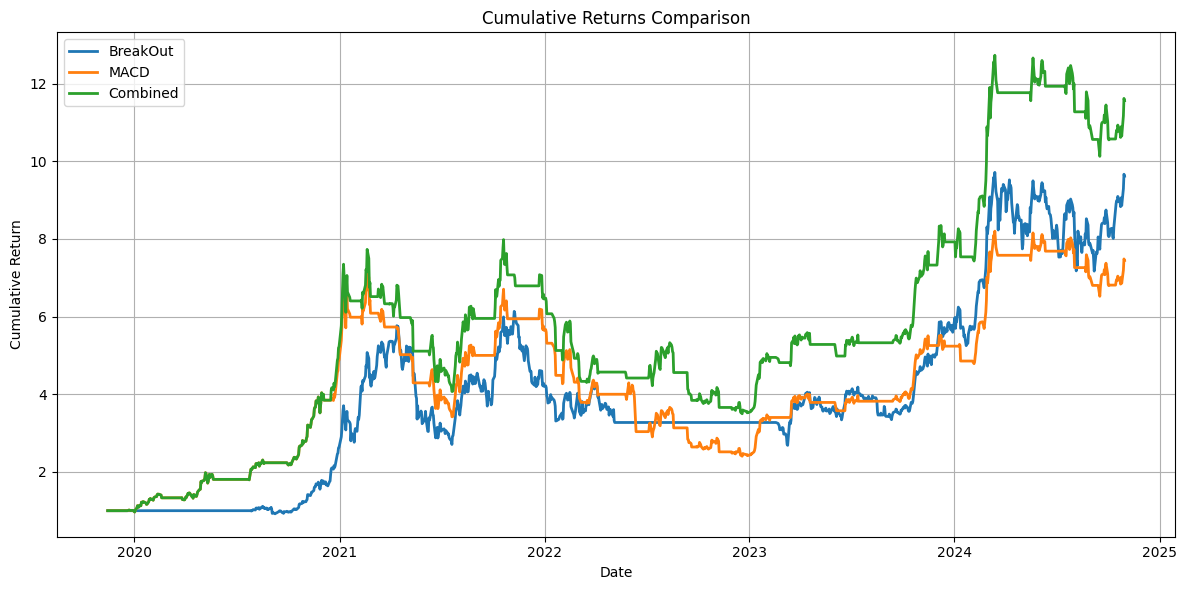

In [86]:
df1 = df1.sort_values(by='date')
df2 = df2.sort_values(by='date')
df3 = df3.sort_values(by='date')

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(df1['date'], df1['cumulative_return'], label='BreakOut', linewidth=2)
plt.plot(df2['date'], df2['cumulative_return'], label='MACD', linewidth=2)
plt.plot(df3['date'], df3['cumulative_return'], label='Combined', linewidth=2)

# Chart details
plt.title('Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()
